In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import os

## getting data ready

In [ ]:
train_dir = "/content/drive/MyDrive/ml/crops_classification/data/train"
test_dir = "/content/drive/MyDrive/ml/crops_classification/data/test"
val_dir = "/content/drive/MyDrive/ml/crops_classification/data/val"

In [ ]:
# we are using EfficientNet_B0 model, so we are getting the default weights for the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),])

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=transform, target_transform=None)
test_data = datasets.ImageFolder(test_dir,transform=transform, target_transform=None)
val_data = datasets.ImageFolder(val_dir,transform=simple_transform)

In [ ]:
class_names = train_data.classes
# class_names

In [ ]:
len(train_data), len(test_data), len(val_data)

In [ ]:
# creating data batches

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# writing device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## creating model

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# overview of the model's architecture
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

In [ ]:
# freezing the layers
for params in model.features.parameters():
  params.requires_grad=False

In [ ]:
# customizing the classification as per our need
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [ ]:
summary(model)

## training the model

In [ ]:
# creating loss, optimizer and accuracy function for evaluating the model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
#  this function is to train the model

def train_model(model, dataloader, optimizer, loss_fn, accuracy_fn):
  train_loss,train_accuracy=0,0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    model.train()
    y_logits = model(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y)
    train_loss+=loss.item()
    train_accuracy+=accuracy_fn(y_true=y, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return{
      "train_loss": train_loss/len(dataloader),
      "train_accuracy": train_accuracy/len(dataloader)
  }

In [ ]:
# this function is to test the model
def test_model(model, dataloader, optimizer,loss_fn, accuracy_fn):
  test_loss, test_accuracy = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      loss = loss_fn(y_logits, y)
      test_loss+=loss.item()
      test_accuracy+=accuracy_fn(y_true=y, y_pred=y_pred)

  return{
      "test_loss": test_loss/len(dataloader),
      "test_accuracy": test_accuracy/len(dataloader)
  }


In [ ]:
# this functions trains and tests the model for specified number of epochs
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, epochs):
  results = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []
  }

  for epoch in tqdm(range(epochs)):
    train_data = train_model(model, train_dataloader, optimizer, loss_fn, accuracy_fn)
    test_data = test_model(model, test_dataloader, optimizer, loss_fn, accuracy_fn)
    print(f"Epoch: {epoch+1}")
    print(f"train_loss: {train_data['train_loss']} | train_accuracy: {train_data['train_accuracy']}")
    print(f"test_loss: {test_data['test_loss']} | test_accuracy: {test_data['test_accuracy']}")

    results["test_accuracy"].append(test_data["test_accuracy"])
    results["test_loss"].append(test_data["test_loss"])
    results["train_accuracy"].append(train_data["train_accuracy"])
    results["train_loss"].append(train_data["train_loss"])

  return results


In [ ]:
# training starts
epochs=10
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, epochs)

## saving and loading the model

In [ ]:
torch.save(model,"/content/drive/MyDrive/ml/crops_classification/model.pt")

In [ ]:
model = torch.load("/content/drive/MyDrive/ml/crops_classification/model.pt",map_location=torch.device(device))

## visualization

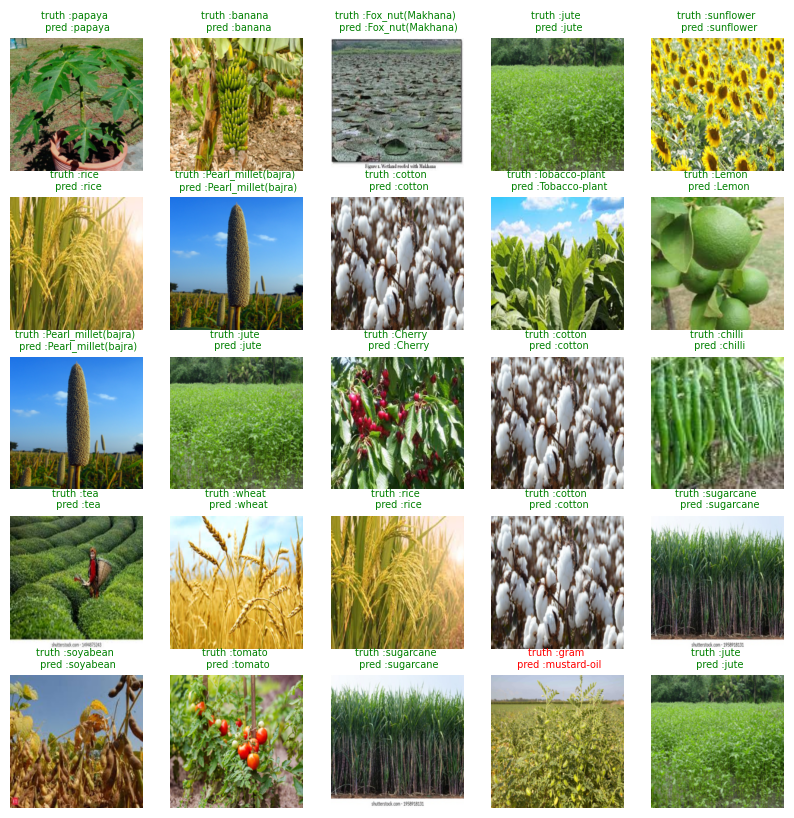

In [ ]:
def pred_and_plot(model):
  model.eval()
  with torch.inference_mode():

    plt.figure(figsize=(10,10))

    for i in range(25):
      random_idx=torch.randint(len(val_data),size=(1,))
      img, label = val_data[random_idx]

      # convering the simple transformed image to PIL
      to_pil = transforms.ToPILImage()
      transformed_image = to_pil(img)

      # transforming the PIL image to EfficientNet_B0 default weighted tensor
      transformed_image = transform(transformed_image)

      #preforming predictions
      y_logits = model(transformed_image.unsqueeze(dim=0).to(device))
      y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      y_label = class_names[y_pred]
      y_true = class_names[label]


      #plotting the image
      plt.subplot(5,5,i+1)

      color = "green" if y_label == y_true else "red"
      plt.imshow(img.permute(1,2,0))
      plt.title(f"truth :{y_true} \n pred :{y_label}", color=color,fontsize=7)
      plt.axis("off")

    plt.plot()

pred_and_plot(model)

In [ ]:
def eval_model(model, dataloader):
  model.eval()
  with torch.inference_mode():
    y_preds = []
    for X, y in dataloader:

      to_pil = transforms.ToPILImage()
      pil_image = to_pil(X)
      transformed_image = transform(pil_image)

      y_logits = model(transformed_image.unsqueeze(dim=0).to(device))
      y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      y_preds.append(y_pred)

    return torch.cat(y_preds)

In [ ]:
y_true = torch.tensor([label for _, label in val_data])
y_preds = eval_model(model, val_data)


In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics

from torchmetrics.classification import MulticlassConfusionMatrix

matrix = MulticlassConfusionMatrix(num_classes=len(class_names))
mat = matrix(y_preds, y_true)

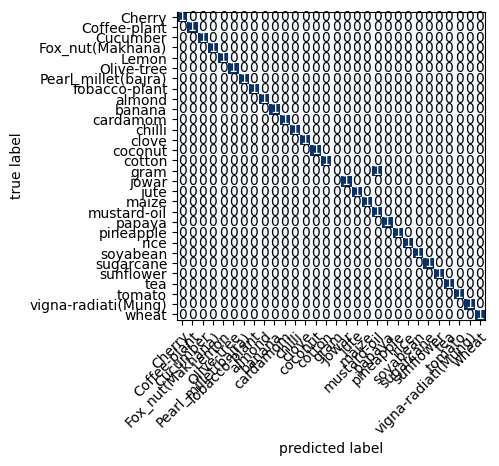

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = mat.to("cpu").numpy(),figsize=(4,4), class_names=class_names);